In [64]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.ndimage import rotate, zoom
from Filters.filters import edge_detect

In [2]:
all_images = []
for group in ["CN","MCI","AD"]:
    with open(f"Data/{group}.npy","br") as f:
        images = np.load(f)
    i_start = len(all_images)
    all_images.extend(images)
    print(group, i_start,":",len(all_images))
all_images = np.stack(all_images)
print(all_images.shape)

all_brain_slices = all_images[:, 40, :, :]

CN 0 : 1326
MCI 1326 : 1787
AD 1787 : 2000
(2000, 80, 96, 80)


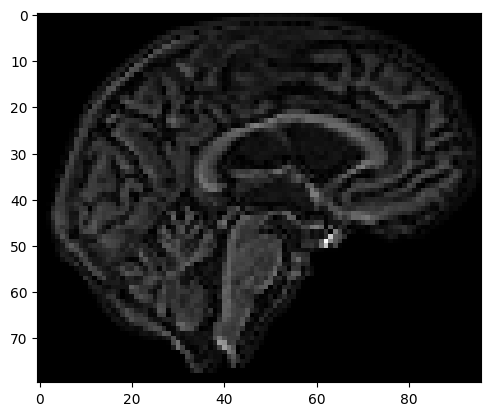

In [89]:
plt.imshow(np.rot90(edge_detect(all_brain_slices[0], 2,alpha=0,abs_=True)), cmap="gray")

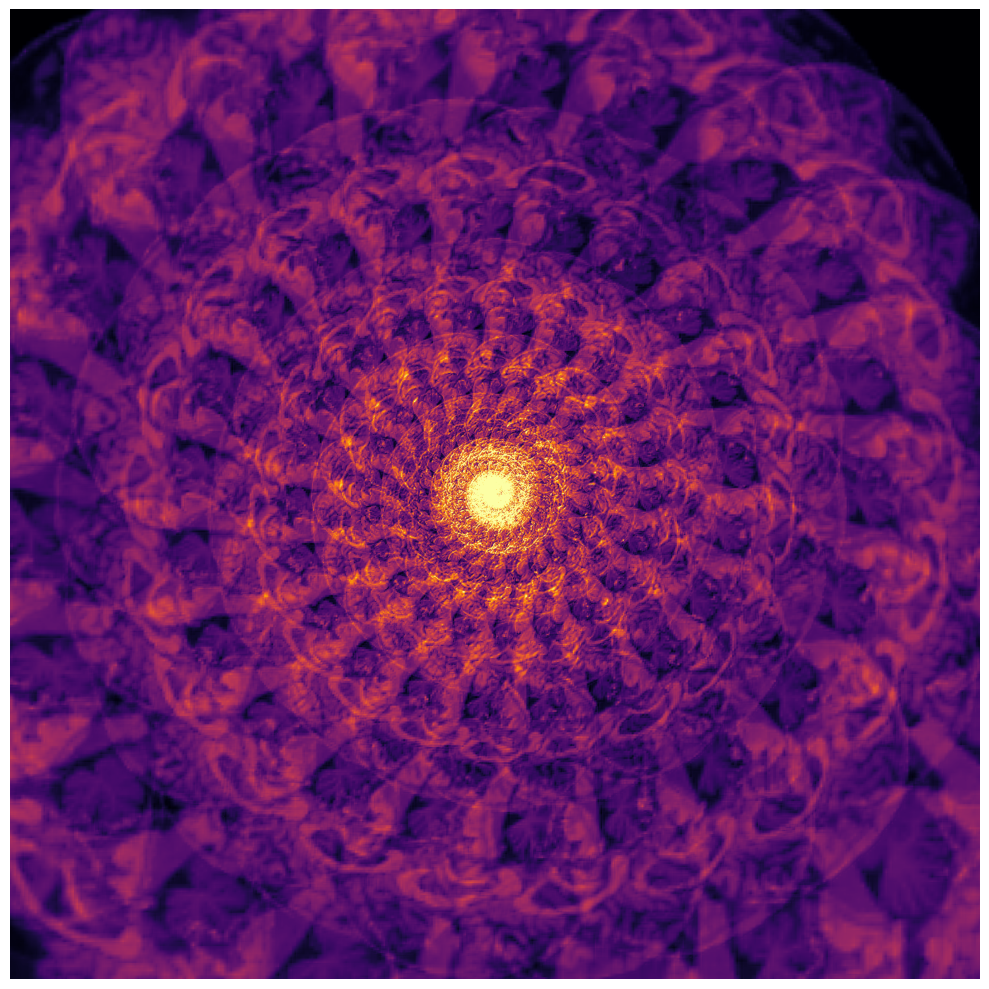

In [131]:

canvas_size = 2048
center = canvas_size // 2
num_slices = 150#len(all_brain_slices)
radius = 350  # max radius for spiral

# Create canvas
canvas = np.zeros((canvas_size, canvas_size))

# Spiral parameters
turns = 7
theta_max = 2 * np.pi * turns
r_step = radius / num_slices

for i in range(num_slices):
    slice_img = all_brain_slices[i]
    slice_img = (slice_img - slice_img.min()) / (slice_img.ptp())  # normalize to 0-1
    slice_img = slice_img * 0.3  # reduce intensity for additive blending

    theta = theta_max * i / num_slices
    r = r_step * i
    r_step += (0.4+r*0.004)*0.023

    x = int(center + r * np.cos(theta))
    y = int(center - r * np.sin(theta))

    angle = np.degrees(theta)  # rotate to face outward
    rotated_slice = rotate(slice_img, angle, reshape=True, order=1)
    rotated_slice = zoom(rotated_slice, (0.4+r*0.004)*1.7, order=1)
    rotated_slice = edge_detect(rotated_slice, 2,alpha=0.3,abs_=True)
    # rotated_slice = edge_detect(rotated_slice, 2,alpha=0.3,abs_=True)
    rotated_slice = edge_detect(rotated_slice, 1,alpha=0.3,abs_=True)
    rotated_slice = edge_detect(rotated_slice, 1,alpha=0.3,abs_=True)

    h, w = rotated_slice.shape
    x0, y0 = x - w // 2, y - h // 2

    # Add to canvas with additive blend
    # Determine the valid canvas area
    x0_canvas = max(x0, 0)
    y0_canvas = max(y0, 0)
    x1_canvas = min(x0 + w, canvas_size)
    y1_canvas = min(y0 + h, canvas_size)

    # Corresponding area on the image slice
    x0_slice = x0_canvas - x0
    y0_slice = y0_canvas - y0
    x1_slice = x0_slice + (x1_canvas - x0_canvas)
    y1_slice = y0_slice + (y1_canvas - y0_canvas)

    # Add only the overlapping region
    try:
        canvas[y0_canvas:y1_canvas, x0_canvas:x1_canvas] += rotated_slice[y0_slice:y1_slice, x0_slice:x1_slice]
    except: continue

# Normalize image
canvas = np.clip(canvas, 0, 1)

# Convert to image
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(canvas, cmap='inferno')
ax.axis('off')
plt.tight_layout()
plt.show()

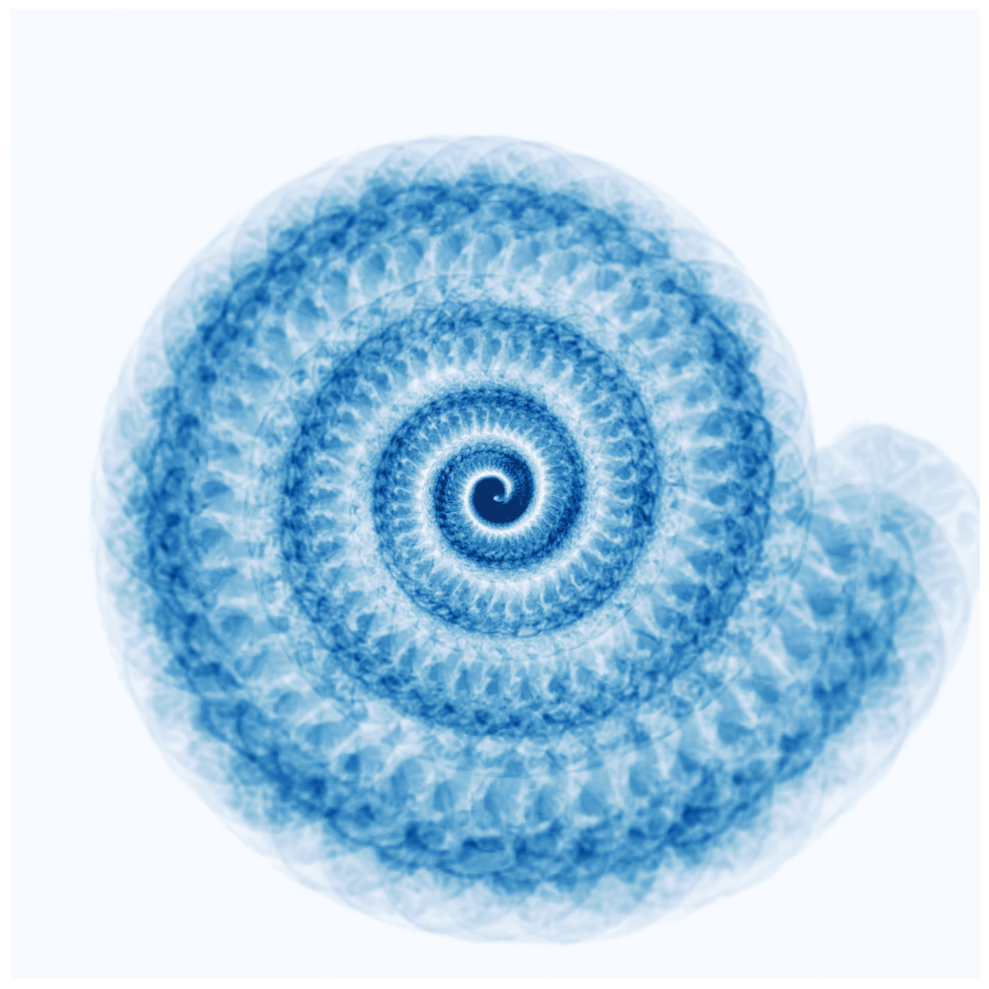

In [59]:

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(canvas, cmap='Blues')
ax.axis('off')
plt.tight_layout()
plt.show()